# Análisis de imágen con Python

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.cluster import KMeans
from scipy import ndimage
import skimage as skim
from skimage import color
from skimage import io
from skimage.color import label2rgb
from skimage.measure import regionprops
import pandas as pd

### En primer lugar se abre la imagen y visualiza

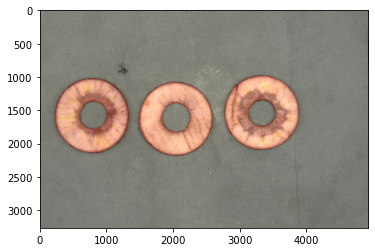

In [2]:
img = skim.io.imread("0 trehalosa/melaessiccata 0.5h.jpg")  # abro el archivo de imagen
img_lab = color.rgb2lab(img, illuminant='D65', observer='2')  # img_Lab es un array de numpy de 3 dimensiones (L, a, b)

plt.imshow(img);

### Se aplicará el método kmeans para eliminar el fondo

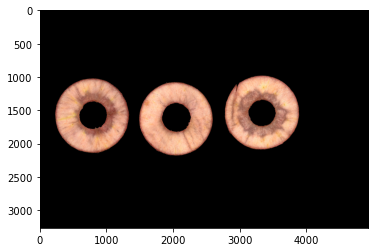

In [3]:
ab = img_lab[:,:,1:3]  # Extraigo las componentes a y b, correspondientes a las matrices :,:,1 y :,:,2
nrows = ab.shape[0]  # Cuento el número de filas
ncols = ab.shape[1]  # Cuento el número de columnas
ab = np.reshape(ab,[nrows*ncols,2])  # reorganizo la matriz ab de manera de tener una matriz en 1-D
kmeans = KMeans(n_clusters=2, random_state=0).fit(ab)  # kmeans para separar dos poblaciones (el color del fondo y el color de las muestras)
pixel_labels = np.reshape(kmeans.labels_,[nrows,ncols])  # En esta matriz están los labels de cada pixel etiquetado por kmeans  
rgb_label = np.repeat(pixel_labels[:, :, np.newaxis], 3, axis=2)  # Label en 3-D para poder aplicarlo a la imagen original
img_clean = img * rgb_label  # Multiplicando la imagen original por rgb_label del kmeans, elimino el fondo ya que pertence a la poblacion identificada con 0

plt.imshow(img_clean);

### El siguiente paso consiste en identificar los objetos para poder recortarlos

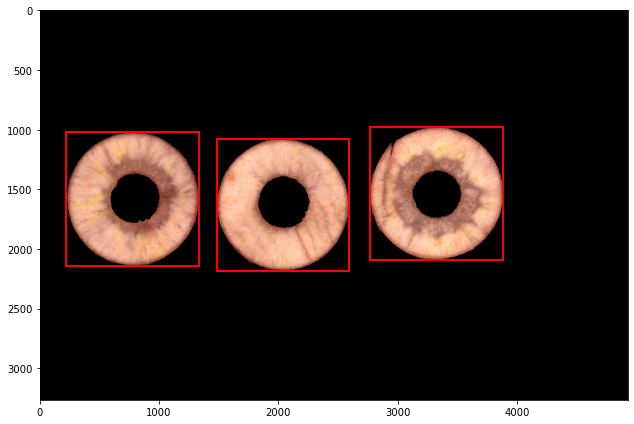

In [4]:
labeled, nr_objects = ndimage.label(img_clean[:,:,0])  # Etiquetado de la imagen por el canal R
fig, ax = plt.subplots(figsize=(10, 6))  # Creo un subplot para visualizar los objetos identificados
ax.imshow(img_clean)

imagenes = {}  # Diccionario donde se almacenará cada objeto identificado y recortado
i = 0  # Valor incial del contador i

for region in regionprops(labeled):  # Loop que itera en cada region identificada mediante regionprops en la imagen etiquetada anteriormente
    if region.area >= 100:  # Condición para considerar regiones grandes, sirve como filtro
        y1, x1, y2, x2 = region.bbox  # Mediante el método bbox se extrae la información correspondiente a la posición de las regiones
        rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1,  # utilizando este paquete se crean rectángulos alrededor de los objetos identificados
                                   fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect) # Agrega el rectángulo al subplot creado anteriormente
        imagenes[i] = img_clean[y1:y2, x1:x2, :]  # Recorta el objeto identificado según las coordenadas de la región
        i = i + 1  # Actualiza el valor del contador
plt.tight_layout()
plt.show()

### Aquí se grafican los objetos recortados en un mismo gráfico

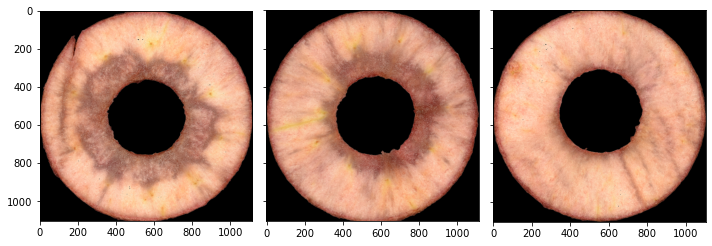

In [6]:
fig, ax = plt.subplots(1,3,figsize=(10, 6),tight_layout=True, sharey=True)
ax[0].imshow(imagenes[0])
ax[1].imshow(imagenes[1])
ax[2].imshow(imagenes[2]);
# plt.savefig('manzanas.png')

### A continuación se crea un diccionario con las imagenes recortadas y convertidas a uint8 después ser guardada en archivo de imágen

In [7]:
fotos = {'imagen1': imagenes[0].astype(np.ubyte),
         'imagen2': imagenes[1].astype(np.ubyte),
         'imagen3': imagenes[2].astype(np.ubyte)};

In [8]:
skim.io.imsave("melaessiccata 0.5h_1.png",fotos['imagen1'])
skim.io.imsave("melaessiccata 0.5h_2.png",fotos['imagen2'])
skim.io.imsave("melaessiccata 0.5h_3.png",fotos['imagen3'])

### Por último se extraen los valores de color de cada imágen en el espacio CIE $L^*a^*b^*$

In [10]:
df = pd.DataFrame(columns = ['Muestra', 'L', 'a', 'b'])  # DataFrame donde se almacenarán los valores de color

objetos_lab = {}  # Diccionario donde se guardan las imagenes convertidas a L a b
i = 0  # Valor incial del contador i
for imagen in fotos:
    objetos_lab[i] = color.rgb2lab(fotos[imagen], illuminant='D65', observer='2')  # Convierte cada imagen a L a b
    L = np.round(np.nanmean(np.where(objetos_lab[i][:,:,0]!=0,objetos_lab[i][:,:,0],np.nan)),decimals=2)  # Calcula el promedio de L en la primer matriz sin tener en cuenta los 0
    a = np.round(np.nanmean(np.where(objetos_lab[i][:,:,1]!=0,objetos_lab[i][:,:,1],np.nan)),decimals=2)  # porque los convierte en NaN y la función promedio no los considera
    b = np.round(np.nanmean(np.where(objetos_lab[i][:,:,2]!=0,objetos_lab[i][:,:,2],np.nan)),decimals=2)  # además redondea los valores obtenidos a 2 decimales
    nueva_fila = {'Muestra':imagen, 'L':L, 'a':a, 'b':b} # Diccionario donde almacena los valores calculados en cada Loop
    df = df.append(nueva_fila, ignore_index=True)  # Agrega los valores calculados al DataFrame inicial
    i = i+1
df.to_excel('tabla_color.xlsx',index=False)  # Guarda la tabla de colores en un archivo excel
df

,Muestra,L,a,b
0,imagen1,67.80,19.85,24.05
1,imagen2,65.01,21.23,23.84
2,imagen3,72.38,20.26,24.82
